In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import tensorflow_hub as hub

2022-11-02 11:12:00.534116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


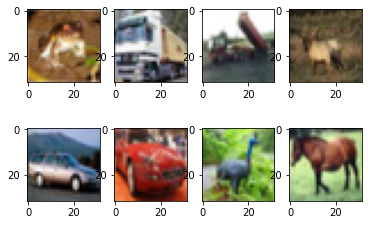

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

For model I, We utilized transfer learning to predict the labels of the image. BY comparing the result from different transfered models, we select the ResNet50 model, since it gives us the best performance. After the transfered model, I add several dense layers with activation function "relu", dropout layer and batch normalization layer in order to prevent overfitting. The whole training process takes about 40 minutes and get a training accuracy around 0.29 and a validation accuracy around 0.24. 

In [7]:
## split train and test for clean data
print(clean_labels.shape)
print(imgs[:10000].shape)
n_samples=imgs[:10000].shape[0]
perm = np.random.permutation(n_samples)
test_size = int(n_samples * 0.2)
val_idx = perm[:test_size]
train_idx = perm[test_size:]
Y_train_clean, X_train_clean = clean_labels[train_idx], imgs[:10000][train_idx]
Y_test_clean, X_test_clean= clean_labels[val_idx], imgs[:10000][val_idx]
print(X_train_clean.shape,Y_train_clean.shape,X_test_clean.shape,Y_test_clean.shape)#train/test split
Y_noise=noisy_labels[10000:]
X_noise=imgs[10000:]
print(Y_noise.shape,X_noise.shape)

(10000,)
(10000, 32, 32, 3)
(8000, 32, 32, 3) (8000,) (2000, 32, 32, 3) (2000,)
(40000,) (40000, 32, 32, 3)


In [8]:
Y_1=noisy_labels[:10000][train_idx]

In [9]:
# train a transfer learning model
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', 
                                                   input_shape=(32, 32, 3),
                                                   include_top=False)#include_top=False means not include the output layer
base_model.trainable = False #Do not train the transfered model again
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)#make sure to use the corresponding preprocessing
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(10,activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3) #early stopping: let the training process stops when it reaches a maximum

2022-11-02 11:13:11.784332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [11]:
import time

start = time.time()
history = model.fit(X_noise,Y_noise, epochs=100, validation_split=0.2,callbacks=[early_stopping])
end = time.time()

print('Model 1 training takes '+ str(end - start)+ ' seconds')

Epoch 1/100
1000/1000 [==============================] - 117s 115ms/step - loss: 2.5710 - sparse_categorical_accuracy: 0.1388 - val_loss: 2.3802 - val_sparse_categorical_accuracy: 0.1786
Epoch 2/100
1000/1000 [==============================] - 111s 111ms/step - loss: 2.3978 - sparse_categorical_accuracy: 0.1768 - val_loss: 2.3396 - val_sparse_categorical_accuracy: 0.1950
Epoch 3/100
1000/1000 [==============================] - 112s 112ms/step - loss: 2.3297 - sparse_categorical_accuracy: 0.1951 - val_loss: 2.3164 - val_sparse_categorical_accuracy: 0.2049
Epoch 4/100
1000/1000 [==============================] - 109s 109ms/step - loss: 2.2868 - sparse_categorical_accuracy: 0.2050 - val_loss: 2.3029 - val_sparse_categorical_accuracy: 0.2156
Epoch 5/100
1000/1000 [==============================] - 114s 114ms/step - loss: 2.2504 - sparse_categorical_accuracy: 0.2195 - val_loss: 2.2902 - val_sparse_categorical_accuracy: 0.2164
Epoch 6/100
1000/1000 [==============================] - 111s 111

In [12]:
#define the model_I
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image=image[np.newaxis,:]
    return np.argmax(model.predict(image),axis=-1)

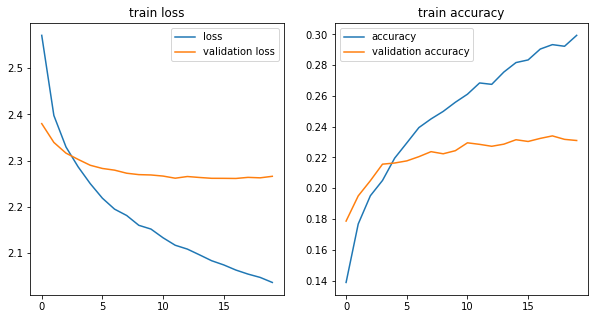

In [13]:
#make plots about loss and accuracy
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].legend(["loss", "validation loss"])
ax[0].title.set_text("train loss")
ax[1].plot(history.history["sparse_categorical_accuracy"])
ax[1].plot(history.history["val_sparse_categorical_accuracy"])
ax[1].legend(["accuracy", "validation accuracy"])
ax[1].title.set_text("train accuracy")

### 2.3. Model II

Considering the labels are noisy, we add weakly supervised learning features to the model I. We first pre-process 
the noisy label before implementing model I on the rare dataset. To approach this, we first leverage CNN (LeNet) 
to learn and train from only clean labels and then apply this CNN to correct noisy labels. After label corrections,
the new/cleaned dataset is introduced to the model I trained in the previous step.

In [14]:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision

In [15]:
# construct LeNet model
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        #self.fc1 = nn.Linear(64*5*5,120)
        #self.fc2 = nn.Linear(120,84)
        #self.fc3 = nn.Linear(84,10)
        self.maxpool = nn.MaxPool2d(2, 2)
        

    def forward(self, out):
        out = F.relu(self.conv1(out))
        out = self.maxpool(out)
        out = F.relu(self.conv2(out))
        out = self.maxpool(out)
        out = torch.flatten(out, 1) #Flatten
        return out
    
#  Take images and noisy labels as input, and then treat clean labels as one consideration of loss functions 
class Clean_Label(nn.Module):
    def __init__(self,LeNet):
        super(Clean_Label, self).__init__()
        self.LeNet=LeNet
        self.fc11 = nn.LazyLinear(out_features=32)
        self.fc12 = nn.LazyLinear(out_features=32)
        self.fc2 = nn.LazyLinear(out_features=10)
        
    def forward(self,out1,out2):
        noisy=out2
        out1=self.LeNet(out1)
        out1=self.fc11(out1)
        out2=self.fc12(out2)
        out = torch.cat([out1,out2],dim=1)
        out = self.fc2(out)
        out = out+noisy
        return out

# Construct a dataset with clean labels 
class Clean_Data(Dataset):
    def __init__(self, image ,noisy, clean):
        self.image=image
        self.clean=clean
        self.noisy=noisy

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        out=self.image[idx,]
        clean=self.clean[idx,]
        noisy=self.noisy[idx,] 
        return(out,noisy,clean)

Y_1_1=F.one_hot(torch.tensor(Y_1.astype(np.int64))).numpy()
Y_train_clean_1= F.one_hot(torch.tensor(Y_train_clean.astype(np.int64))).numpy()
data = Clean_Data(X_train_clean,Y_1_1,Y_train_clean_1)

In [16]:
trainloader = torch.utils.data.DataLoader(dataset=data,batch_size=10,shuffle=True)
Lenet = LeNet()
labelnet=Clean_Label(Lenet)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(labelnet.parameters(), lr=0.001, weight_decay=6e-4)

for epoch in range(20): #For loop
    result_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        #Transfer to the data into torch format
        inputs,noisy,clean = data
        inputs=np.transpose(inputs.to(torch.float32), (0,3,1,2)) #move channel from postion 3 to position 1
        noisy=noisy.to(torch.float32)
        clean=clean.to(torch.float32)
        
        #Zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = labelnet(inputs,noisy)
        loss = criterion(outputs,clean)
        loss.backward()
        optimizer.step()

        #Print
        result_loss += loss.item()
    print(f'epoch:{epoch + 1} | loss: {result_loss/700:.6f}') #Batch size=10, iteration=700
    result_loss = 0.0 #reset loss

/Users/donglaixu/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch:1 | loss: 2.268386
epoch:2 | loss: 1.693289
epoch:3 | loss: 1.466222
epoch:4 | loss: 1.326001
epoch:5 | loss: 1.181574
epoch:6 | loss: 1.086313
epoch:7 | loss: 0.979156
epoch:8 | loss: 0.893468
epoch:9 | loss: 0.812070
epoch:10 | loss: 0.732919
epoch:11 | loss: 0.660230
epoch:12 | loss: 0.597273
epoch:13 | loss: 0.549735
epoch:14 | loss: 0.528128
epoch:15 | loss: 0.491158
epoch:16 | loss: 0.433168
epoch:17 | loss: 0.451087
epoch:18 | loss: 0.360646
epoch:19 | loss: 0.412202
epoch:20 | loss: 0.371493


In [17]:
#generate new labels for noisy data
Y_noise_1= F.one_hot(torch.tensor(Y_noise.astype(np.int64))).numpy()
new_label = labelnet(np.transpose(torch.from_numpy(X_noise).to(torch.float32), (0,3,1,2)),torch.from_numpy(Y_noise_1).to(torch.float32))
new_label= np.argmax(new_label.detach().numpy(),1)

In [18]:
#construct the same model as Model_I and fit with generated data
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', 
                                                   input_shape=(32, 32, 3),
                                                   include_top=False)#include_top=False means not include the output layer
base_model.trainable = False #Do not train the transfered model again
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)#make sure to use the corresponding preprocessing
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation="relu")(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(10,activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
history1=model1.fit(X_noise,new_label, epochs=100, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/100
1000/1000 [==============================] - 108s 104ms/step - loss: 1.9818 - sparse_categorical_accuracy: 0.3180 - val_loss: 1.7309 - val_sparse_categorical_accuracy: 0.3938
Epoch 2/100
1000/1000 [==============================] - 104s 104ms/step - loss: 1.7251 - sparse_categorical_accuracy: 0.3931 - val_loss: 1.6645 - val_sparse_categorical_accuracy: 0.4193
Epoch 3/100
1000/1000 [==============================] - 105s 104ms/step - loss: 1.6652 - sparse_categorical_accuracy: 0.4165 - val_loss: 1.6388 - val_sparse_categorical_accuracy: 0.4330
Epoch 4/100
1000/1000 [==============================] - 105s 105ms/step - loss: 1.6211 - sparse_categorical_accuracy: 0.4314 - val_loss: 1.6281 - val_sparse_categorical_accuracy: 0.4356
Epoch 5/100
1000/1000 [==============================] - 106s 106ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.4429 - val_loss: 1.6106 - val_sparse_categorical_accuracy: 0.4421
Epoch 6/100
1000/1000 [==============================] - 108s 108

In [19]:
## define model II
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image=image[np.newaxis,:]
    return np.argmax(model1.predict(image), axis = -1)

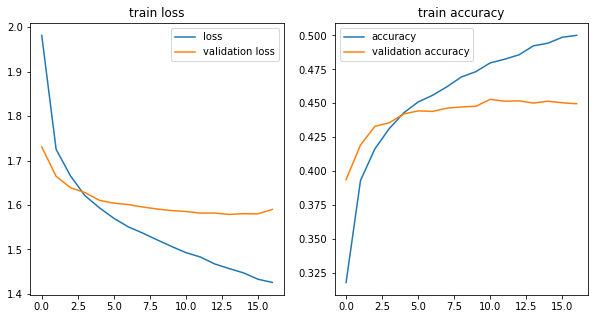

In [20]:
#make plots about loss and accuracy
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history1.history["loss"])
ax[0].plot(history1.history["val_loss"])
ax[0].legend(["loss", "validation loss"])
ax[0].title.set_text("train loss")
ax[1].plot(history1.history["sparse_categorical_accuracy"])
ax[1].plot(history1.history["val_sparse_categorical_accuracy"])
ax[1].legend(["accuracy", "validation accuracy"])
ax[1].title.set_text("train accuracy")

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [21]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
'''
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
    
evaluation(baseline_model, test_labels, test_imgs)
'''

In [23]:
#evaluation on baseline_model
evaluation(baseline_model, Y_test_clean, X_test_clean)

              precision    recall  f1-score   support

           0       0.38      0.50      0.43       211
           1       0.21      0.39      0.28       183
           2       0.24      0.04      0.07       204
           3       0.23      0.12      0.16       208
           4       0.25      0.53      0.34       198
           5       0.23      0.14      0.17       182
           6       0.32      0.36      0.34       253
           7       0.28      0.04      0.06       194
           8       0.25      0.41      0.31       184
           9       0.25      0.14      0.18       183

    accuracy                           0.27      2000
   macro avg       0.26      0.27      0.24      2000
weighted avg       0.27      0.27      0.24      2000



In [24]:
#evaluation on Model_I
evaluation(model_I, Y_test_clean, X_test_clean)

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       211
           1       0.57      0.57      0.57       183
           2       0.50      0.42      0.45       204
           3       0.41      0.36      0.38       208
           4       0.47      0.45      0.46       198
           5       0.45      0.45      0.45       182
           6       0.60      0.62      0.61       253
           7       0.51      0.56      0.53       194
           8       0.60      0.64      0.62       184
           9       0.53      0.59      0.56       183

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [25]:
#evaluation on Model_II
evaluation(model_II, Y_test_clean, X_test_clean)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

           0       0.66      0.54      0.59       211
           1       0.66      0.63      0.64       183
           2       0.49      0.51      0.50       204
           3       0.41      0.42      0.41       208
           4       0.45      0.61      0.52       198
           5       0.60      0.43      0.50       182
           6       0.67      0.63      0.65       253
           7       0.72      0.45      0.56       194
           8       0.61      0.76      0.67       184
           9       0.60      0.78      0.68       183

    accuracy                           0.57      2000
   macro avg       0.59      0.58      0.57      2000
weighted avg       0.59      0.57      0.57      2000



In [ ]:
#Prediction
#Save to CSV File for testing dataset
n_test = 10000
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

#Read the csv file
df = pd.read_csv("../data/label_prediction.csv")

#Generate predicted values
baseline_model_pred = list()
modelI_pred = list()
modelII_pred = list()

for img in test_imgs:
    baseline_model_pred.append(baseline_model(img))
    modelI_pred.append(modelI(img))
    modelII_pred.append(modelII(img))

df["Baseline"] = baseline_model_pred
df["Model I"] = modelI_pred
df["Model II"] = modelII_pred

#Save the csv to output folder
df.to_csv("../output/label_prediction.csv")

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.